In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import lab2rgb, rgb2lab
import sys
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler

In [2]:
OUTPUT_TEMPLATE = (
    'Bayesian classifier: {bayes_rgb:.3g} {bayes_lab:.3g}\n'
    'kNN classifier:      {knn_rgb:.3g} {knn_lab:.3g}\n'
    'SVM classifier:      {svm_rgb:.3g} {svm_lab:.3g}\n'
)

In [3]:
# representative RGB colours for each label, for nice display
COLOUR_RGB = {
    'red': (255, 0, 0),
    'orange': (255, 114, 0),
    'yellow': (255, 255, 0),
    'green': (0, 230, 0),
    'blue': (0, 0, 255),
    'purple': (187, 0, 187),
    'brown': (117, 60, 0),
    'pink': (255, 187, 187),
    'black': (0, 0, 0),
    'grey': (150, 150, 150),
    'white': (255, 255, 255),
}
name_to_rgb = np.vectorize(COLOUR_RGB.get, otypes=[np.uint8, np.uint8, np.uint8])

In [4]:
def plot_predictions(model, lum=71, resolution=256):
    """
    Create a slice of LAB colour space with given luminance; predict with the model; plot the results.
    """
    wid = resolution
    hei = resolution
    n_ticks = 5

    # create a hei*wid grid of LAB colour values, with L=lum
    ag = np.linspace(-100, 100, wid)
    bg = np.linspace(-100, 100, hei)
    aa, bb = np.meshgrid(ag, bg)
    ll = lum * np.ones((hei, wid))
    lab_grid = np.stack([ll, aa, bb], axis=2)

    # convert to RGB for consistency with original input
    X_grid = lab2rgb(lab_grid)

    # predict and convert predictions to colours so we can see what's happening
    y_grid = model.predict(X_grid.reshape((wid*hei, 3)))
    pixels = np.stack(name_to_rgb(y_grid), axis=1) / 255
    pixels = pixels.reshape((hei, wid, 3))

    # plot input and predictions
    plt.figure(figsize=(10, 5))
    plt.suptitle('Predictions at L=%g' % (lum,))
    plt.subplot(1, 2, 1)
    plt.title('Inputs')
    plt.xticks(np.linspace(0, wid, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.yticks(np.linspace(0, hei, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.xlabel('A')
    plt.ylabel('B')
    plt.imshow(X_grid.reshape((hei, wid, 3)))

    plt.subplot(1, 2, 2)
    plt.title('Predicted Labels')
    plt.xticks(np.linspace(0, wid, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.yticks(np.linspace(0, hei, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.xlabel('A')
    plt.imshow(pixels)

In [5]:
def main():
    data = pd.read_csv(sys.argv[1] if len(sys.argv) == 2 else 'colour-data.csv')
    X = data[['R', 'G', 'B']].values / 255
    y = data['Label'].values
    
    # split the data
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    
    # function to transform rgb to lab
    def convert_to_lab(X):
        X = np.array(X).reshape(1,-1,3)
        return rgb2lab(X).reshape(-1,3) 
    # TODO: create some models
    # naive bayes
    bayes_rgb_model = GaussianNB()
    bayes_lab_model = make_pipeline(
        FunctionTransformer(func=convert_to_lab, validate=True),
        GaussianNB()
    )
    # KNN - uses 10-fold cross validation for selecting best k
    knn = KNeighborsClassifier()
    knn_params = {'n_neighbors': np.arange(1,20)}
    knn_rgb_model = make_pipeline(
        StandardScaler(),
        GridSearchCV(knn, knn_params, cv=10, iid=False)
    )
    
    knn_lab_model = make_pipeline(
        FunctionTransformer(func=convert_to_lab, validate=True),
        StandardScaler(),
        GridSearchCV(knn, knn_params, cv=10, iid=False)     
    )
    
    # SVM - uses 10-fold cross validation for selecting best k
    svm = SVC(gamma='scale')
    svm_params = {'C': np.arange(1.0, 10.0)}
    
    svc_rgb_model = make_pipeline(
        GridSearchCV(svm, svm_params, cv=10, iid=False)
    )
    svc_lab_model = make_pipeline(
        FunctionTransformer(func=convert_to_lab, validate=True),
        GridSearchCV(svm, svm_params, cv=10, iid=False)
    )
    # train each model and output image of predictions
    
    models = [bayes_rgb_model, bayes_lab_model, knn_rgb_model, knn_lab_model, svc_rgb_model, svc_lab_model]
    for i, m in enumerate(models):  # yes, you can leave this loop in if you want.
        m.fit(X_train, y_train)
        plot_predictions(m)
        plt.savefig('predictions-%i.png' % (i,))

    print(OUTPUT_TEMPLATE.format(
        bayes_rgb=bayes_rgb_model.score(X_valid, y_valid),
        bayes_lab=bayes_lab_model.score(X_valid, y_valid),
        knn_rgb=knn_rgb_model.score(X_valid, y_valid),
        knn_lab=knn_lab_model.score(X_valid, y_valid),
        svm_rgb=svc_rgb_model.score(X_valid, y_valid),
        svm_lab=svc_lab_model.score(X_valid, y_valid),
    ))

Bayesian classifier: 0.559 0.617
kNN classifier:      0.752 0.755
SVM classifier:      0.765 0.766



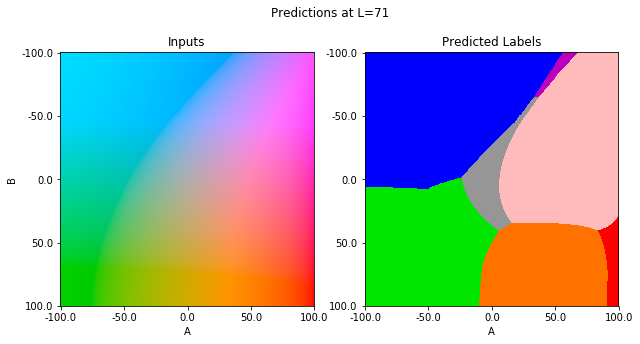

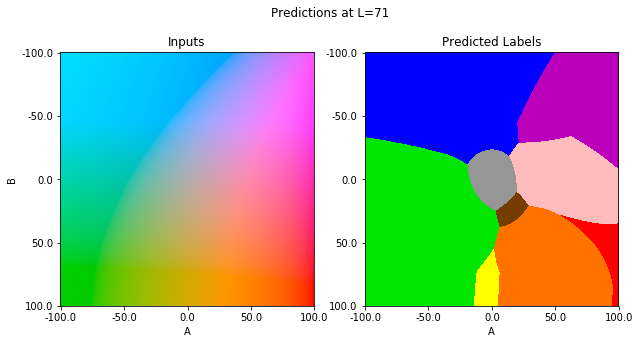

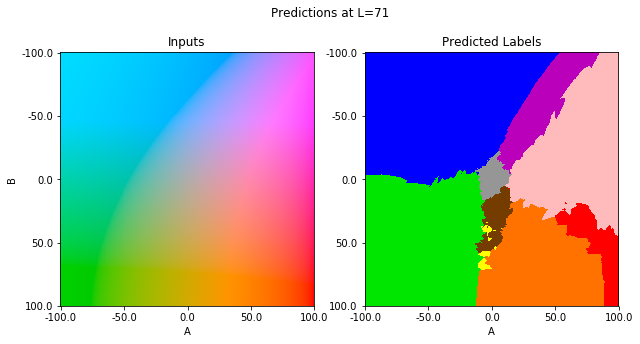

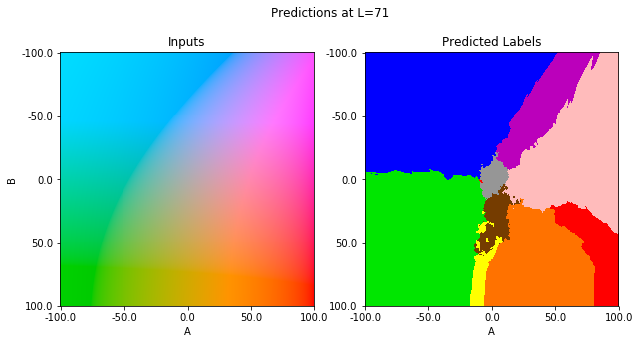

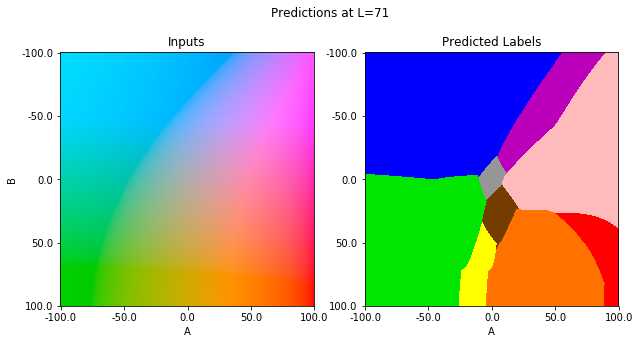

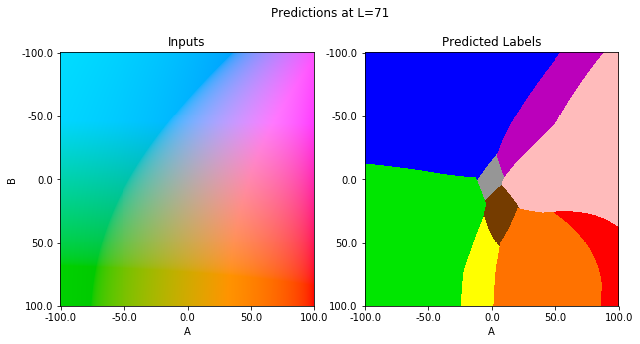

In [6]:
if __name__ == '__main__':
    main()